In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/levelhuggingfacedata/L2_BookCorpus.txt
/kaggle/input/levelhuggingfacedata/L1_ChildrenStories.txt
/kaggle/input/levelhuggingfacedata/L3_CNN_DailyMail.txt
/kaggle/input/levelhuggingfacedata/L4_S2ORC.txt
/kaggle/input/smalllevelhuggingfacedata/L2_BookCorpus.txt
/kaggle/input/smalllevelhuggingfacedata/L1_ChildrenStories.txt
/kaggle/input/smalllevelhuggingfacedata/L3_CNN_DailyMail.txt
/kaggle/input/smalllevelhuggingfacedata/L4_S2ORC.txt
/kaggle/input/multileveltextdata/L2.txt
/kaggle/input/multileveltextdata/L4.txt
/kaggle/input/multileveltextdata/L1.txt
/kaggle/input/multileveltextdata/L3.txt


# Data Import

In [2]:
# # import requests

# with open("/kaggle/input/multileveltextdata/L1.txt", "r", encoding="utf-8") as f:
#     L1 = f.read()
# with open("/kaggle/input/multileveltextdata/L2.txt", "r", encoding="utf-8") as f:
#     L2 = f.read()
# with open("/kaggle/input/multileveltextdata/L3.txt", "r", encoding="utf-8") as f:
#     L3 = f.read()
# with open("/kaggle/input/multileveltextdata/L4.txt", "r", encoding="utf-8") as f:
#     L4 = f.read()

## Hugging Face Dataset

In [3]:
import requests

with open("/kaggle/input/smalllevelhuggingfacedata/L1_ChildrenStories.txt", "r", encoding="utf-8") as f:
    L1 = f.read()
with open("/kaggle/input/smalllevelhuggingfacedata/L2_BookCorpus.txt", "r", encoding="utf-8") as f:
    L2 = f.read()
with open("/kaggle/input/smalllevelhuggingfacedata/L3_CNN_DailyMail.txt", "r", encoding="utf-8") as f:
    L3 = f.read()
with open("/kaggle/input/smalllevelhuggingfacedata/L4_S2ORC.txt", "r", encoding="utf-8") as f:
    L4 = f.read()

# Data Cleaning

In [4]:
!pip install emoji
import re
import emoji

# Define allowed character sets
english_regex = r"[a-zA-Z0-9\s]"                   # English letters, numbers, spaces
math_symbols  = r"[\+\-\*/=<>∑∫√πθΣ∂∞]"             # Add more math symbols if needed
special_chars = r"[\.,!?;:'\"()\[\]{}#@%^&*_~]"     # Common special characters

# Function to clean a given text
def clean_text(text):
    return "".join(
        c for c in text
        if re.match(english_regex, c) or 
           re.match(math_symbols, c) or 
           re.match(special_chars, c) or 
           emoji.is_emoji(c)
    )

# Apply cleaning to all levels
L1_cleaned = clean_text(L1)
L2_cleaned = clean_text(L2)
L3_cleaned = clean_text(L3)
L4_cleaned = clean_text(L4)

print("All levels cleaned and stored in *_cleaned variables!")


All levels cleaned and stored in *_cleaned variables!


In [5]:
full_text = L1_cleaned+L2_cleaned+L3_cleaned+L4_cleaned
D = len(full_text)
D

419274144

# Data Stats

In [6]:
chars = sorted(list(set(full_text)))
vocab_size = len(chars)

token = full_text.encode("utf-8")
def get_stats(ids):
    counts = {} # Creates an empty Dictionary
    for pair in zip(ids,ids[1:]):
        counts[pair] = counts.get(pair ,0)+1
    return counts
print(vocab_size)
print(''.join(chars))
stats = get_stats(token)
top_pair = max(stats,key=stats.get)
top_pair

207
	
 !"#%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[]^_abcdefghijklmnopqrstuvwxyz{}~ ©®Σθπ  ™↔↘↪∂∑√∞∫▪▫▶☀☁☄☺♀♣♥♦♻⚙⚠⚡✏✔✨❤🌈🌍🌏🌐🌞🌟🌬🌱🌳🌸🌻🌿🍃🍇🍊🍞🍡🍭🎉🎮🎶🏠🏡🏰🏼🏽🐇🐛🐦🐰🐿👑👧👨💁💎💕💖💚💡💪💻💾📃📊📚📝📡📣📱📲🔒🔗🔬🕊🖥🗣😁😂😃😄😊😎😐😔😢😮🚀🚧🚯🤖🤩🤯🥗🥦🦉🦋🦝


(101, 32)

# BPE

In [7]:
# def merge(ids, pair, idx):
#   # in the list of ints (ids), replace all consecutive occurences of pair with the new token idx
#   newids = []
#   i = 0
#   while i < len(ids):
#     # if we are not at the very last position AND the pair matches, replace it
#     if i < len(ids) - 1 and ids[i] == pair[0] and ids[i+1] == pair[1]:
#       newids.append(idx)
#       i += 2
#     else:
#       newids.append(ids[i])
#       i += 1
#   return newids
# vocab_size = 2000 # the desired final vocabulary size
# num_merges = vocab_size - 256
# ids = list(token) # copy so we don't destroy the original list

# merges = {} # (int, int) -> int
# for i in range(num_merges):
#   stats = get_stats(ids)
#   pair = max(stats, key=stats.get)
#   idx = 256 + i
#   print(f"merging {pair} into a new token {idx}")
#   ids = merge(ids, pair, idx)
#   merges[pair] = idx

# vocab = {idx: bytes([idx]) for idx in range(256)}
# for (p0, p1), idx in merges.items():
#     vocab[idx] = vocab[p0] + vocab[p1]

# def decode(ids):
#   # given ids (list of integers), return Python string
#   tokens = b"".join(vocab[idx] for idx in ids)
#   text = tokens.decode("utf-8", errors="replace")
#   return text

# print(decode([122]))

# merges

# def encode(text):
#   # given a string, return list of integers (the tokens)
#   tokens = list(text.encode("utf-8"))
#   while len(tokens) >= 2:
#     stats = get_stats(tokens)
#     pair = min(stats, key=lambda p: merges.get(p, float("inf")))
#     if pair not in merges:
#       break # nothing else can be merged
#     idx = merges[pair]
#     tokens = merge(tokens, pair, idx)
#   return tokens

# print(encode("hello world"))

In [8]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import ByteLevel
from tokenizers.decoders import ByteLevel as ByteLevelDecoder

# Your cleaned text data
docs = [L1_cleaned, L2_cleaned, L3_cleaned, L4_cleaned]

# Break large documents into smaller lines/chunks
def chunked_docs():
    for doc in docs:
        # You can tweak the split here (e.g., '. ' or '\n' or custom logic)
        for line in doc.split('\n'):
            line = line.strip()
            if line:
                yield line

# Initialize BPE tokenizer
tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
tokenizer.pre_tokenizer = ByteLevel()
tokenizer.decoder = ByteLevelDecoder()

# Trainer with manageable vocab size
trainer = BpeTrainer(vocab_size=10000, special_tokens=["[UNK]"])

# Train using iterator to save memory
tokenizer.train_from_iterator(chunked_docs(), trainer=trainer)

# Check final vocab size
print("Actual vocab size:", tokenizer.get_vocab_size())





Actual vocab size: 10000


In [9]:
def encode(text: str) -> list[int]:
    return tokenizer.encode(text).ids

def decode(token_ids: list[int]) -> str:
    return tokenizer.decode(token_ids)
sample = "math is beautiful ✨"
ids = encode(sample)
print("→", ids)
print("←", decode(ids))

→ [5387, 245, 1373, 123, 120, 151, 98]
←  math is beautiful ✨


# GPT Like Transformer

In [10]:
import os
import torch
import torch.nn as nn
from torch.nn import functional as F

# ------------------ Hyperparameters ------------------
# batch_size = 16 # how many independent sequences will we process in parallel?
# block_size = 32 # what is the maximum context length for predictions?
# max_iters = 5000
# eval_interval = 100
# learning_rate = 1e-3
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# eval_iters = 200
# n_embd = 64
# n_head = 4
# n_layer = 4
# dropout = 0.0
# # ------------
# # # hyperparameters for GPU
batch_size = 128 # how many independent sequences will we process in parallel?
block_size = 512 # what is the maximum context length for predictions?
max_iters = 10000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2
# # # ------------

torch.manual_seed(1337)

# ------------------ BPE tokenizer functions (assumed defined) ------------------
# encode(text) -> list of token ids
# decode(ids)   -> string
# merges, vocab, etc. already built above in your notebook

# ------------------ Data loader for transformer ------------------
def get_batch_transformer(data):
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x  = torch.stack([data[i:i+block_size] for i in ix]).to(device)
    y  = torch.stack([data[i+1:i+block_size+1] for i in ix]).to(device)
    return x, y

@torch.no_grad()
def estimate_loss_transformer(model, train_data, val_data):
    model.eval()
    out = {}
    for split, data in zip(['train','val'], [train_data, val_data]):
        losses = []
        for _ in range(eval_iters):
            X, Y = get_batch_transformer(data)
            _, loss = model(X, Y)
            losses.append(loss.item())
        out[split] = sum(losses) / len(losses)
    model.train()
    return out

def compute_perplexity(loss):
    return torch.exp(torch.tensor(loss))

# ------------------ Transformer model classes ------------------
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key   = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x); q = self.query(x)
        wei = q @ k.transpose(-2,-1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T,:T]==0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        return wei @ v

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj  = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        return self.dropout(self.proj(out))

class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4*n_embd),
            nn.ReLU(),
            nn.Linear(4*n_embd, n_embd),
            nn.Dropout(dropout),
        )
    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa    = MultiHeadAttention(n_head, head_size)
        self.ffwd  = FeedForward(n_embd)
        self.ln1   = nn.LayerNorm(n_embd)
        self.ln2   = nn.LayerNorm(n_embd)
    def forward(self, x):
        x = x + self.sa(self.ln1(x))   # Residual connection after self-attention
        x = x + self.ffwd(self.ln2(x)) # Residual connection after feedforward
        return x

class GPTLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table    = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head) for _ in range(n_layer)])
        self.ln_f   = nn.LayerNorm(n_embd)
        self.lm_head= nn.Linear(n_embd, vocab_size)
        self.apply(self._init_weights)
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        loss = None
        if targets is not None:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets= targets.view(B*T)
            loss   = F.cross_entropy(logits, targets)
        return logits, loss
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _= self(idx_cond)
            logits = logits[:, -1, :]
            probs  = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

# ------------------ Incremental Training Pipeline ------------------
import matplotlib.pyplot as plt

def incremental_training_pipeline(level_texts, model, checkpoint_dir="checkpoints"):
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Store metrics for plotting
    all_metrics = {
        "level": [],
        "iters": [],
        "train_loss": [],
        "val_loss": [],
        "train_ppl": [],
        "val_ppl": [],
    }

    for level_i, level_text in enumerate(level_texts, start=1):
        print(f"\n=== LEVEL {level_i} TRAINING ===")
        data_ids   = torch.tensor(encode(level_text), dtype=torch.long).to(device)
        n          = int(0.9 * data_ids.size(0))
        train_data = data_ids[:n]
        val_data   = data_ids[n:]

        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
        for it in range(max_iters):
            if it % eval_interval == 0:
                losses = estimate_loss_transformer(model, train_data, val_data)
                ppl_train = compute_perplexity(losses['train'])
                ppl_val   = compute_perplexity(losses['val'])

                # Store for later plotting
                all_metrics["level"].append(level_i)
                all_metrics["iters"].append(it)
                all_metrics["train_loss"].append(losses['train'])
                all_metrics["val_loss"].append(losses['val'])
                all_metrics["train_ppl"].append(ppl_train.item())
                all_metrics["val_ppl"].append(ppl_val.item())

                print(f" it={it:4d} | train loss {losses['train']:.4f}  ppl {ppl_train:.2f}  | "
                      f"val loss {losses['val']:.4f}  ppl {ppl_val:.2f}")

            xb, yb = get_batch_transformer(train_data)
            logits, loss = model(xb, yb)
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

        # final evaluation
        losses = estimate_loss_transformer(model, train_data, val_data)
        ppl_train = compute_perplexity(losses['train'])
        ppl_val   = compute_perplexity(losses['val'])

        print(f"\n*** Level {level_i} complete.")
        print(f"    Final train loss {losses['train']:.4f}, ppl {ppl_train:.2f}")
        print(f"    Final   val loss {losses['val']:.4f}, ppl {ppl_val:.2f}")

        # sample generation
        context = torch.zeros((1,1), dtype=torch.long, device=device)
        sample_ids = model.generate(context, max_new_tokens=500)[0].tolist()
        print("    Sample:", decode(sample_ids))

        # save checkpoint
        cp = os.path.join(checkpoint_dir, f"model_level{level_i}.pt")
        torch.save(model.state_dict(), cp)
        print(f"    → Saved checkpoint: {cp}")

    return model, all_metrics


# ------------------ Usage ------------------
# Make sure: L1, L2, L3, L4_cleaned are already in your notebook
level_texts = [L1_cleaned, L2_cleaned, L3_cleaned, L4_cleaned]

# 'vocab_size' must match your BPE final vocabulary size (e.g. 276)
vocab_size = tokenizer.get_vocab_size()
model = GPTLanguageModel(vocab_size).to(device)

model,all_metrics = incremental_training_pipeline(level_texts, model)



=== LEVEL 1 TRAINING ===
 it=   0 | train loss 9.2623  ppl 10533.74  | val loss 9.2632  ppl 10542.38
 it= 500 | train loss 4.4678  ppl 87.17  | val loss 4.4760  ppl 87.88
 it=1000 | train loss 3.8781  ppl 48.33  | val loss 3.9048  ppl 49.64
 it=1500 | train loss 3.6013  ppl 36.65  | val loss 3.6382  ppl 38.02
 it=2000 | train loss 3.4002  ppl 29.97  | val loss 3.4623  ppl 31.89
 it=2500 | train loss 3.2713  ppl 26.35  | val loss 3.3343  ppl 28.06
 it=3000 | train loss 3.1776  ppl 23.99  | val loss 3.2479  ppl 25.74
 it=3500 | train loss 3.0984  ppl 22.16  | val loss 3.1780  ppl 24.00
 it=4000 | train loss 3.0311  ppl 20.72  | val loss 3.1171  ppl 22.58
 it=4500 | train loss 2.9812  ppl 19.71  | val loss 3.0719  ppl 21.58
 it=5000 | train loss 2.9354  ppl 18.83  | val loss 3.0348  ppl 20.80
 it=5500 | train loss 2.8900  ppl 17.99  | val loss 3.0000  ppl 20.09
 it=6000 | train loss 2.8533  ppl 17.34  | val loss 2.9677  ppl 19.45
 it=6500 | train loss 2.8266  ppl 16.89  | val loss 2.9377

In [28]:
for i, level in enumerate(level_texts, start=1):
    D = len(level)
    total_tokens_seen = block_size * batch_size * max_iters
    epochs = total_tokens_seen / D
    print(f"Total Epochs for Level {i}: {epochs:.4f}")



Total Epochs for Level 1: 3.1340
Total Epochs for Level 2: 3.1029
Total Epochs for Level 3: 3.1256
Total Epochs for Level 4: 3.1424


In [18]:
# For Shakespeare input prompt 
# # Example Shakespearean prompt
prompt = "Who is the President of USA "

# # Encode the prompt using your trained BPE tokenizer
encoded = encode(prompt)

# # Truncate if the prompt is longer than block_size
if len(encoded) > block_size:
    encoded = encoded[-block_size:]

# # Create context tensor
context = torch.tensor([encoded], dtype=torch.long, device=device)

# # Generate continuation
generated_ids = model.generate(context, max_new_tokens=1000)[0].tolist()

# # Decode and print the generated text
print(decode(generated_ids))

 Who is the President of USA  and its contribution is taken from the community such as the domaination here members of a Southern country with the destination a author's hobe Network. The position of USA is two aspects: when different scholars have used for swarmer's lives, to design solutions for development throughout the year or process of research.I. INTRODUCTIONNowadi been intend to the more general opinion of each three industry connections worldwide. It was not used here to enable more than shifts from a very highway perspective or sector to be used during competition to a highway. Also, one resultant increase in all scenarios has a serious role in defining changes in the economy [1]. Some countries embedded on the grid have been invested in a quiet process. The specific architecture to include an important conclusion that one can take have when the origin of higher than another proposal, as nearby a SO clearly possible, if a certain security value or threat has been present or 

In [19]:
import matplotlib.pyplot as plt

def plot_metrics(all_metrics):
    levels = sorted(set(all_metrics["level"]))
    for level in levels:
        # Get indices for this level
        idxs = [i for i, l in enumerate(all_metrics["level"]) if l == level]
        iters = [all_metrics["iters"][i] for i in idxs]
        val_loss = [all_metrics["val_loss"][i] for i in idxs]
        val_ppl  = [all_metrics["val_ppl"][i] for i in idxs]

        # Create figure and first y-axis (for loss)
        fig, ax1 = plt.subplots(figsize=(10, 5))
        ax1.plot(iters, val_loss, color='blue', label='Validation Loss')
        ax1.set_xlabel('Iterations')
        ax1.set_ylabel('Validation Loss', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')

        # Second y-axis for perplexity
        ax2 = ax1.twinx()
        ax2.plot(iters, val_ppl, color='green', label='Validation Perplexity')
        ax2.set_ylabel('Validation Perplexity', color='green')
        ax2.tick_params(axis='y', labelcolor='green')

        plt.title(f'Level {level} - Validation Loss & Perplexity')
        fig.tight_layout()
        plt.grid(True)
        plt.show()


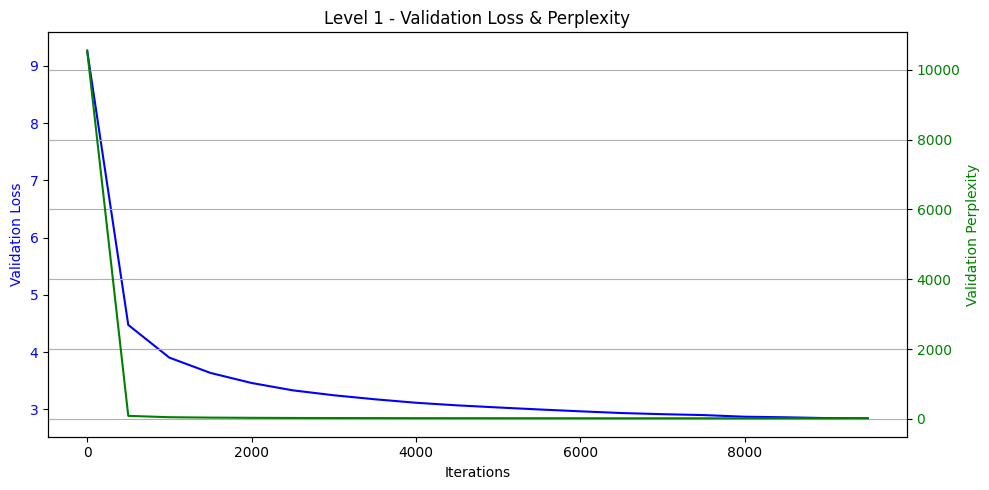

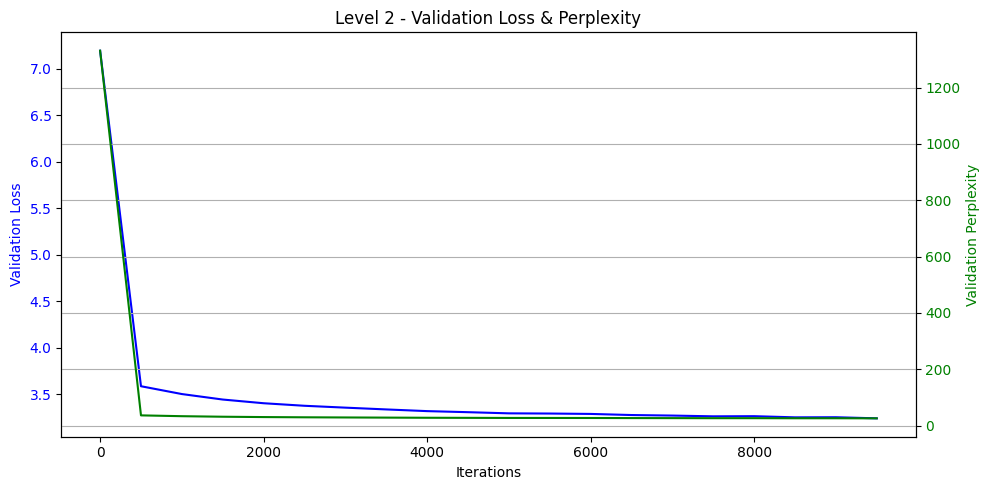

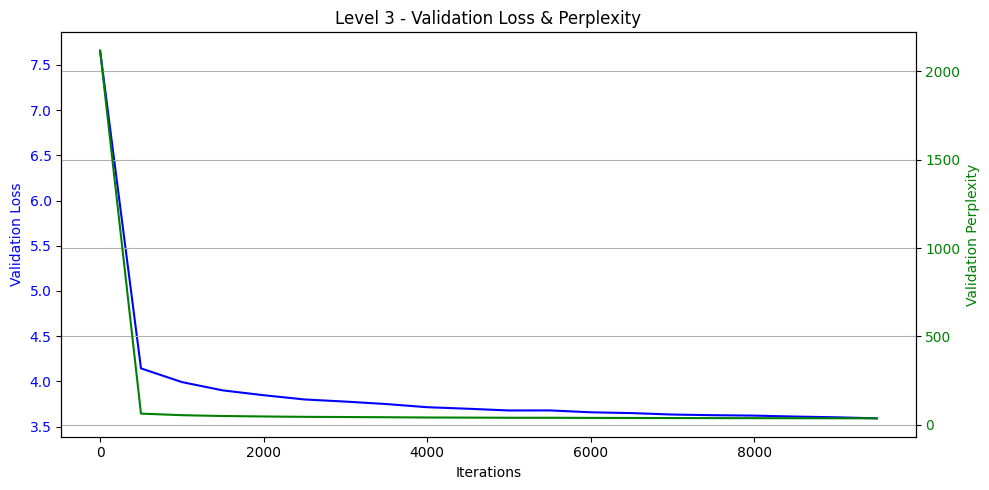

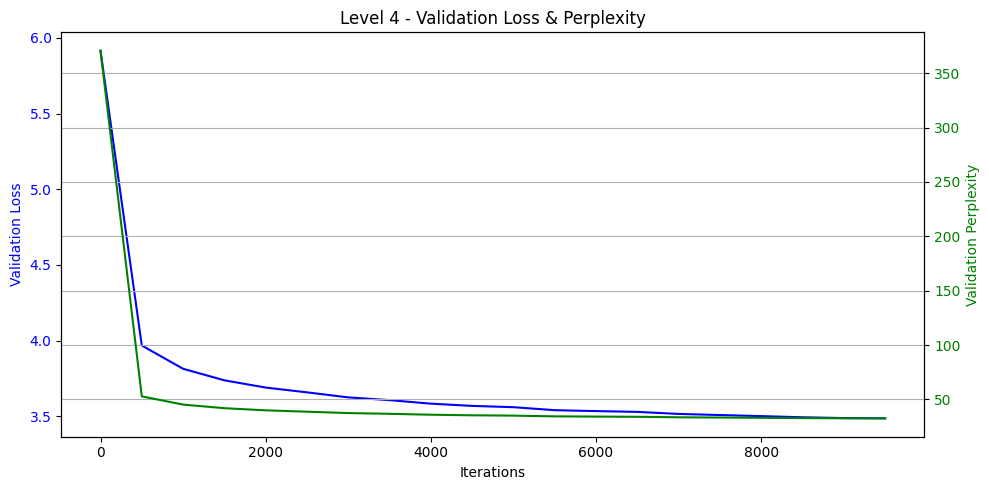

In [20]:
plot_metrics(all_metrics) 

# Sinosudial Positional encoding


In [ ]:
import os
import math
import torch
import torch.nn as nn
from torch.nn import functional as F

# ------------------ Hyperparameters ------------------
# batch_size = 16 # how many independent sequences will we process in parallel?
# block_size = 32 # what is the maximum context length for predictions?
# max_iters = 5000
# eval_interval = 100
# learning_rate = 1e-3
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# eval_iters = 200
# n_embd = 64
# n_head = 4
# n_layer = 4
# dropout = 0.0
# # ------------
# # # hyperparameters for GPU
batch_size = 128 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?
max_iters = 10000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2
# # # ------------

torch.manual_seed(1337)

# ------------------ BPE tokenizer functions (assumed defined) ------------------
# encode(text) -> list of token ids
# decode(ids)   -> string
# merges, vocab, etc. already built above in your notebook

# ------------------ Data loader for transformer ------------------
def get_batch_transformer(data):
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x  = torch.stack([data[i:i+block_size] for i in ix]).to(device)
    y  = torch.stack([data[i+1:i+block_size+1] for i in ix]).to(device)
    return x, y

@torch.no_grad()
def estimate_loss_transformer(model, train_data, val_data):
    model.eval()
    out = {}
    for split, data in zip(['train','val'], [train_data, val_data]):
        losses = []
        for _ in range(eval_iters):
            X, Y = get_batch_transformer(data)
            _, loss = model(X, Y)
            losses.append(loss.item())
        out[split] = sum(losses) / len(losses)
    model.train()
    return out

def compute_perplexity(loss):
    return torch.exp(torch.tensor(loss))

# Using Sinusodial Positional Encoding
def get_sinusoidal_encoding(seq_len, d_model):
    position = torch.arange(seq_len).unsqueeze(1)         # [seq_len, 1]
    div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
    pe = torch.zeros(seq_len, d_model)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe  # [seq_len, d_model]
    
def apply_rope(x, sin, cos):
    x1 = x[..., ::2]  # even indices
    x2 = x[..., 1::2] # odd indices
    x_rotated = torch.cat([x1 * cos - x2 * sin, x1 * sin + x2 * cos], dim=-1)
    return x_rotated
    
def build_rope_cache(seq_len, dim, device):
    theta = 10000.0 ** (-torch.arange(0, dim, 2).float() / dim)
    pos = torch.arange(seq_len, dtype=torch.float32)
    freqs = torch.einsum("i,j->ij", pos, theta)  # [seq_len, dim/2]

    sin = torch.sin(freqs).to(device)
    cos = torch.cos(freqs).to(device)
    return sin, cos  # shape: [seq_len, dim/2]



# ------------------ Transformer model classes ------------------
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key   = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x); q = self.query(x)
        wei = q @ k.transpose(-2,-1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T,:T]==0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        return wei @ v

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj  = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        return self.dropout(self.proj(out))

class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4*n_embd),
            nn.ReLU(),
            nn.Linear(4*n_embd, n_embd),
            nn.Dropout(dropout),
        )
    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa    = MultiHeadAttention(n_head, head_size)
        self.ffwd  = FeedForward(n_embd)
        self.ln1   = nn.LayerNorm(n_embd)
        self.ln2   = nn.LayerNorm(n_embd)
    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


class GPTLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table    = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head) for _ in range(n_layer)])
        self.ln_f   = nn.LayerNorm(n_embd)
        self.lm_head= nn.Linear(n_embd, vocab_size)
        self.apply(self._init_weights)
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        # pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # GPT used this, that is it had Embedding matrix, trained with the model and not use sinosodial function
        pos_emb = get_sinusoidal_encoding(T, n_embd).to(device)
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        loss = None
        if targets is not None:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets= targets.view(B*T)
            loss   = F.cross_entropy(logits, targets)
        return logits, loss
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _= self(idx_cond)
            logits = logits[:, -1, :]
            probs  = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

# ------------------ Incremental Training Pipeline ------------------
import matplotlib.pyplot as plt

def incremental_training_pipeline(level_texts, model, checkpoint_dir="checkpoints"):
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Store metrics for plotting
    all_metrics = {
        "level": [],
        "iters": [],
        "train_loss": [],
        "val_loss": [],
        "train_ppl": [],
        "val_ppl": [],
    }

    for level_i, level_text in enumerate(level_texts, start=1):
        print(f"\n=== LEVEL {level_i} TRAINING ===")
        data_ids   = torch.tensor(encode(level_text), dtype=torch.long).to(device)
        n          = int(0.9 * data_ids.size(0))
        train_data = data_ids[:n]
        val_data   = data_ids[n:]

        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
        for it in range(max_iters):
            if it % eval_interval == 0:
                losses = estimate_loss_transformer(model, train_data, val_data)
                ppl_train = compute_perplexity(losses['train'])
                ppl_val   = compute_perplexity(losses['val'])

                # Store for later plotting
                all_metrics["level"].append(level_i)
                all_metrics["iters"].append(it)
                all_metrics["train_loss"].append(losses['train'])
                all_metrics["val_loss"].append(losses['val'])
                all_metrics["train_ppl"].append(ppl_train.item())
                all_metrics["val_ppl"].append(ppl_val.item())

                print(f" it={it:4d} | train loss {losses['train']:.4f}  ppl {ppl_train:.2f}  | "
                      f"val loss {losses['val']:.4f}  ppl {ppl_val:.2f}")

            xb, yb = get_batch_transformer(train_data)
            logits, loss = model(xb, yb)
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

        # final evaluation
        losses = estimate_loss_transformer(model, train_data, val_data)
        ppl_train = compute_perplexity(losses['train'])
        ppl_val   = compute_perplexity(losses['val'])

        print(f"\n*** Level {level_i} complete.")
        print(f"    Final train loss {losses['train']:.4f}, ppl {ppl_train:.2f}")
        print(f"    Final   val loss {losses['val']:.4f}, ppl {ppl_val:.2f}")

        # sample generation
        context = torch.zeros((1,1), dtype=torch.long, device=device)
        sample_ids = model.generate(context, max_new_tokens=500)[0].tolist()
        print("    Sample:", decode(sample_ids))

        # save checkpoint
        cp = os.path.join(checkpoint_dir, f"model_level{level_i}.pt")
        torch.save(model.state_dict(), cp)
        print(f"    → Saved checkpoint: {cp}")

    return model, all_metrics


# ------------------ Usage ------------------
# Make sure: L1, L2, L3, L4_cleaned are already in your notebook
level_texts = [L1_cleaned, L2_cleaned, L3_cleaned, L4_cleaned]

# 'vocab_size' must match your BPE final vocabulary size (e.g. 276)
vocab_size = tokenizer.get_vocab_size()
model = GPTLanguageModel(vocab_size).to(device)

model,all_metrics = incremental_training_pipeline(level_texts, model)

In [ ]:
# For Shakespeare input prompt 
# # Example Shakespearean prompt
prompt = "Who is the President of USA  "

# # Encode the prompt using your trained BPE tokenizer
encoded = encode(prompt)

# # Truncate if the prompt is longer than block_size
if len(encoded) > block_size:
    encoded = encoded[-block_size:]

# # Create context tensor
context = torch.tensor([encoded], dtype=torch.long, device=device)

# # Generate continuation
generated_ids = model.generate(context, max_new_tokens=1000)[0].tolist()

# # Decode and print the generated text
print(decode(generated_ids))

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(all_metrics):
    levels = sorted(set(all_metrics["level"]))
    for level in levels:
        # Get indices for this level
        idxs = [i for i, l in enumerate(all_metrics["level"]) if l == level]
        iters = [all_metrics["iters"][i] for i in idxs]
        val_loss = [all_metrics["val_loss"][i] for i in idxs]
        val_ppl  = [all_metrics["val_ppl"][i] for i in idxs]

        # Create figure and first y-axis (for loss)
        fig, ax1 = plt.subplots(figsize=(10, 5))
        ax1.plot(iters, val_loss, color='blue', label='Validation Loss')
        ax1.set_xlabel('Iterations')
        ax1.set_ylabel('Validation Loss', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')

        # Second y-axis for perplexity
        ax2 = ax1.twinx()
        ax2.plot(iters, val_ppl, color='green', label='Validation Perplexity')
        ax2.set_ylabel('Validation Perplexity', color='green')
        ax2.tick_params(axis='y', labelcolor='green')

        plt.title(f'Level {level} - Validation Loss & Perplexity')
        fig.tight_layout()
        plt.grid(True)
        plt.show()


In [ ]:
plot_metrics(all_metrics) 

# RoPE 

In [ ]:
import os
import math
import torch
import torch.nn as nn
from torch.nn import functional as F

# ------------------ Hyperparameters ------------------
# batch_size = 16 # how many independent sequences will we process in parallel?
# block_size = 32 # what is the maximum context length for predictions?
# max_iters = 5000
# eval_interval = 100
# learning_rate = 1e-3
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# eval_iters = 200
# n_embd = 64
# n_head = 4
# n_layer = 4
# dropout = 0.0
# # ------------
# # # hyperparameters for GPU
batch_size = 128 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?
max_iters = 10000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2
# # # ------------

torch.manual_seed(1337)

# ------------------ BPE tokenizer functions (assumed defined) ------------------
# encode(text) -> list of token ids
# decode(ids)   -> string
# merges, vocab, etc. already built above in your notebook

# ------------------ Data loader for transformer ------------------
def get_batch_transformer(split_data):
    ix = torch.randint(len(split_data) - block_size, (batch_size,))
    x = torch.stack([split_data[i:i+block_size] for i in ix])
    y = torch.stack([split_data[i+1:i+1+block_size] for i in ix])
    return x.to(device), y.to(device)


@torch.no_grad()
def estimate_loss_transformer(model, train_data, val_data):
    model.eval()
    out = {}
    for split, data in zip(['train','val'], [train_data, val_data]):
        losses = []
        for _ in range(eval_iters):
            X, Y = get_batch_transformer(data)
            _, loss = model(X, Y)
            losses.append(loss.item())
        out[split] = sum(losses) / len(losses)
    model.train()
    return out

def compute_perplexity(loss):
    return torch.exp(torch.tensor(loss))

def apply_rope(x, sin, cos):
    # x: [B,nh,T,hd], sin/cos: [1,1,T,hd/2]
    x1 = x[..., ::2]   # [B,nh,T,hd/2]
    x2 = x[..., 1::2]  # [B,nh,T,hd/2]
    return torch.cat([x1*cos - x2*sin,
                      x1*sin + x2*cos], dim=-1)  # [B,nh,T,hd]

    
def build_rope_cache(seq_len, dim, device):
    theta = 10000.0 ** (-torch.arange(0, dim, 2).float() / dim)
    pos = torch.arange(seq_len, dtype=torch.float32)
    freqs = torch.einsum("i,j->ij", pos, theta)  # [seq_len, dim/2]

    sin = torch.sin(freqs).to(device)
    cos = torch.cos(freqs).to(device)
    return sin, cos  # shape: [seq_len, dim/2]


# ------------------ Transformer model classes ------------------
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        # Only the projections for key, query, and value
        self.key   = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        # Return the projections of key, query, and value
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        return q, k, v


class MultiHeadAttention(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        self.n_head   = n_head
        self.head_dim = n_embd // n_head
        assert self.head_dim * n_head == n_embd, "n_embd must be divisible by n_head"
        assert self.head_dim % 2 == 0, "head_dim must be even for RoPE"

        self.qkv_proj = nn.Linear(n_embd, 3 * n_embd)
        self.out_proj = nn.Linear(n_embd, n_embd)
        self.dropout  = nn.Dropout(dropout)
        self.rope_cache = {}  # cache for different T
    
    def get_rope(self, T, device):
        if T not in self.rope_cache:
            sin, cos = build_rope_cache(T, self.head_dim, device)
            # reshape to [1, 1, T, head_dim//2]
            self.rope_cache[T] = (sin[None, None, :, :], cos[None, None, :, :])
        return self.rope_cache[T]


    def forward(self, x):
        B, T, C = x.shape
        # 1) project to QKV and reshape+permute to [B, nh, T, head_dim]
        qkv = self.qkv_proj(x)                              # [B, T, 3*C]
        qkv = qkv.view(B, T, self.n_head, 3*self.head_dim)  # [B, T, nh, 3·hd]
        qkv = qkv.permute(0, 2, 1, 3)                       # [B, nh, T, 3·hd]
        q, k, v = qkv.chunk(3, dim=-1)                      # each [B, nh, T, head_dim]

        # 2) apply RoPE to q,k
        sin, cos = self.get_rope(T, x.device)    # [1,1,T,hd/2]
        q = apply_rope(q, sin, cos)
        k = apply_rope(k, sin, cos)


        # 3) scaled dot‑product attention → [B, nh, T, T]
        att = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim)

        # 4) causal mask of shape [1,1,T,T]
        mask = torch.tril(torch.ones(T, T, device=x.device))
        mask = mask.view(1, 1, T, T)
        att = att.masked_fill(mask == 0, float('-inf'))

        # 5) softmax & dropout
        att = F.softmax(att, dim=-1)
        att = self.dropout(att)

        # 6) attend to V → [B, nh, T, head_dim]
        out = att @ v

        # 7) reshape back to [B, T, C] and final proj
        out = out.permute(0, 2, 1, 3).contiguous().view(B, T, C)
        return self.out_proj(out)


class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4*n_embd),
            nn.ReLU(),
            nn.Linear(4*n_embd, n_embd),
            nn.Dropout(dropout),
        )
    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_embd, n_head)
        self.ffwd  = FeedForward(n_embd)
        self.ln1   = nn.LayerNorm(n_embd)
        self.ln2   = nn.LayerNorm(n_embd)
    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head) for _ in range(n_layer)])
        self.ln_f   = nn.LayerNorm(n_embd)
        self.lm_head= nn.Linear(n_embd, vocab_size)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        x = self.token_embedding_table(idx)  # ✅ No pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        loss = None
        if targets is not None:
            logits = logits.view(B*T, -1)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
        self.eval()
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _= self(idx_cond)
            logits = logits[:, -1, :]
            probs  = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

# ------------------ Incremental Training Pipeline ------------------
import matplotlib.pyplot as plt

def incremental_training_pipeline(level_texts, model, checkpoint_dir="checkpoints"):
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Store metrics for plotting
    all_metrics = {
        "level": [],
        "iters": [],
        "train_loss": [],
        "val_loss": [],
        "train_ppl": [],
        "val_ppl": [],
    }

    for level_i, level_text in enumerate(level_texts, start=1):
        print(f"\n=== LEVEL {level_i} TRAINING ===")
        data_ids   = torch.tensor(encode(level_text), dtype=torch.long).to(device)
        n          = int(0.9 * data_ids.size(0))
        train_data = data_ids[:n]
        val_data   = data_ids[n:]

        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
        for it in range(max_iters):
            if it % eval_interval == 0:
                losses = estimate_loss_transformer(model, train_data, val_data)
                ppl_train = compute_perplexity(losses['train'])
                ppl_val   = compute_perplexity(losses['val'])

                # Store for later plotting
                all_metrics["level"].append(level_i)
                all_metrics["iters"].append(it)
                all_metrics["train_loss"].append(losses['train'])
                all_metrics["val_loss"].append(losses['val'])
                all_metrics["train_ppl"].append(ppl_train.item())
                all_metrics["val_ppl"].append(ppl_val.item())

                print(f" it={it:4d} | train loss {losses['train']:.4f}  ppl {ppl_train:.2f}  | "
                      f"val loss {losses['val']:.4f}  ppl {ppl_val:.2f}")

            xb, yb = get_batch_transformer(train_data)
            logits, loss = model(xb, yb)
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

        # final evaluation
        losses = estimate_loss_transformer(model, train_data, val_data)
        ppl_train = compute_perplexity(losses['train'])
        ppl_val   = compute_perplexity(losses['val'])

        print(f"\n*** Level {level_i} complete.")
        print(f"    Final train loss {losses['train']:.4f}, ppl {ppl_train:.2f}")
        print(f"    Final   val loss {losses['val']:.4f}, ppl {ppl_val:.2f}")

        # sample generation
        context = torch.zeros((1,1), dtype=torch.long, device=device)
        sample_ids = model.generate(context, max_new_tokens=500)[0].tolist()
        print("    Sample:", decode(sample_ids))

        # save checkpoint
        cp = os.path.join(checkpoint_dir, f"model_level{level_i}.pt")
        torch.save(model.state_dict(), cp)
        print(f"    → Saved checkpoint: {cp}")

    return model, all_metrics


# ------------------ Usage ------------------
# Make sure: L1, L2, L3, L4_cleaned are already in your notebook
level_texts = [L1_cleaned, L2_cleaned, L3_cleaned, L4_cleaned]

# 'vocab_size' must match your BPE final vocabulary size (e.g. 276)
vocab_size = tokenizer.get_vocab_size()
model = GPTLanguageModel(vocab_size).to(device)

model,all_metrics = incremental_training_pipeline(level_texts, model)

# Performance Matrix

In [ ]:
# For Shakespeare input prompt 
# # Example Shakespearean prompt
prompt = "Who is the President of USA "

# # Encode the prompt using your trained BPE tokenizer
encoded = encode(prompt)

# # Truncate if the prompt is longer than block_size
if len(encoded) > block_size:
    encoded = encoded[-block_size:]

# # Create context tensor
context = torch.tensor([encoded], dtype=torch.long, device=device)

# # Generate continuation
generated_ids = model.generate(context, max_new_tokens=1000)[0].tolist()

# # Decode and print the generated text
print(decode(generated_ids))

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(all_metrics):
    levels = sorted(set(all_metrics["level"]))
    for level in levels:
        # Get indices for this level
        idxs = [i for i, l in enumerate(all_metrics["level"]) if l == level]
        iters = [all_metrics["iters"][i] for i in idxs]
        val_loss = [all_metrics["val_loss"][i] for i in idxs]
        val_ppl  = [all_metrics["val_ppl"][i] for i in idxs]

        # Create figure and first y-axis (for loss)
        fig, ax1 = plt.subplots(figsize=(10, 5))
        ax1.plot(iters, val_loss, color='blue', label='Validation Loss')
        ax1.set_xlabel('Iterations')
        ax1.set_ylabel('Validation Loss', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')

        # Second y-axis for perplexity
        ax2 = ax1.twinx()
        ax2.plot(iters, val_ppl, color='green', label='Validation Perplexity')
        ax2.set_ylabel('Validation Perplexity', color='green')
        ax2.tick_params(axis='y', labelcolor='green')

        plt.title(f'Level {level} - Validation Loss & Perplexity')
        fig.tight_layout()
        plt.grid(True)
        plt.show()


In [ ]:
plot_metrics(all_metrics) 